# Daily Data Forecasting - EUR/GBP Rate (1996-2025)

This notebook presents a comprehensive workflow for forecasting the daily EUR/GBP exchange rate on data from 1996 to 2025 using both statistical and deep learning approaches. We begin by importing and visualizing the data, followed by the computation of technical indicators to enrich the feature set. After ensuring data stationarity, we split the dataset into training, validation, and test sets and apply denoising techniques.

We first establish a statistical baseline using ARIMA models with GARCH effects to capture both mean and volatility dynamics. Next, we develop and evaluate Long Short-Term Memory (LSTM) neural networks, including both standard and probabilistic variants, to forecast future returns. Hyperparameter tuning is performed to optimize model performance.

Finally, we implement simple trading strategies based on the model predictions, comparing the effectiveness of standard and uncertainty-aware (probabilistic) LSTM models in a simulated trading environment.

Throughout the notebook, we emphasize best practices such as avoiding look-ahead bias and quantifying prediction uncertainty, with the goal of providing robust and interpretable forecasting and trading insights.

In [2]:
import glob, os

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate


from statsmodels.tsa.stattools import adfuller
from statsmodels.robust import mad
import pywt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from arch import arch_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# Local imports
from res.file_handler import import_daily_data, augment_daily_data, first_differences_daily_data
from res.LSTMmodel import LSTMRegressor, train_LSTM

# Set random seeds for reproducibility
torch.manual_seed(7)
np.random.seed(7)

# Setup device type
torch.backends.cudnn.benchmark = True
device = torch.device('cuda') if torch.cuda.is_available() else \
        (torch.device('mps') if torch.mps.is_available() else torch.device('cpu'))
device

device(type='mps')

## Datasets Import and Visualization

Daily data from 1st January 1996 to 30th May 2025.

In [3]:
df = import_daily_data("Data/Daily/From_1996")

PRICE_EURGBP = df['EURGBP_Open']
print(df.isnull().sum())
print(f"duplicated dates: {df.index.duplicated().sum()}")
df

EURGBP_Open       0
EURUSD_Open       0
XAUUSD_Open       0
NASDAQ100_Open    0
FTSE100_Open      0
LCOc1_Open        0
GBPUSD_Open       0
VIX_Open          0
dtype: int64
duplicated dates: 0


,EURGBP_Open,EURUSD_Open,XAUUSD_Open,NASDAQ100_Open,FTSE100_Open,LCOc1_Open,GBPUSD_Open,VIX_Open
Exchange Date,,,,,,,,
1996-01-02,0.8254,1.2764,2.584647,450.459991,4490.549805,14.500000,1.5465,13.390000
1996-01-03,0.8230,1.2790,2.562132,459.920013,4514.250000,14.660000,1.5541,11.530000
1996-01-04,0.8223,1.2756,2.537427,447.279999,4508.509766,14.540000,1.5505,11.240000
1996-01-05,0.8242,1.2793,2.536783,438.920013,4459.930176,14.610000,1.5518,14.020000
1996-01-08,0.8286,1.2800,2.528445,439.589996,4477.350098,14.970000,1.5492,14.020000
...,...,...,...,...,...,...,...,...
2025-05-26,0.8398,1.1361,0.298000,18308.980469,10409.580078,57.099998,1.3499,20.750000
2025-05-27,0.8391,1.1386,0.299010,18716.000000,10391.799805,57.160000,1.3562,20.629999
2025-05-28,0.8388,1.1328,0.302840,18997.189453,10472.690430,57.040001,1.3508,19.209999


In [ ]:
def multi_plot(df, data=None, labels=None, colors=None, title="Plot", xlabel="X-axis", ylabel="Y-axis", 
         figsize=(20, 10), grid_style="white", plot_type="line"):
    """
    Parameters:
        data (list of pandas Series): List of data series to plot.
        labels (list of str): Labels for each data series. 
        colors (list of str): Colors for each data series.
        title (str): Title of the plot.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis. 
        figsize (tuple): Size of the figure.
        grid_style (str): Style of the grid.
    """
    if data is None:
        data = [df['EURGBP_Open'], df['EURUSD_Open'], 
                df['GBPUSD_Open'], df['VIX_Open'], 
                df['FTSE100_Open'], df['LCOc1_Open'], 
                df['NASDAQ100_Open'], df['XAUUSD_Open']]
        labels = ['EURGBP', 'EURUSD', 'GBPUSD', 'VIX', 'FTSE100', 'LCOc1', 'NASDAQ100', 'XAUUSD']
        colors=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

    fig, axs = plt.subplots(2, 4, figsize=figsize)
    # Set grid style and figure size
    sns.set(style=grid_style)
    if plot_type == "line":
        for i, ax in enumerate(axs.flat):
            sns.lineplot(x=df.index, y=data[i], label=labels[i], color=colors[i], ax=ax)
            ax.set_title(labels[i])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.legend()
    elif plot_type == "histogram":
        for i, ax in enumerate(axs.flat):
            # Plot histogram
            ax.hist(data[i], bins=30, density=True, alpha=0.6, color=colors[i], label=labels[i])
            # Overlay normal distribution curve
            mean, std = np.mean(data[i]), np.std(data[i])
            x = np.linspace(min(data[i]), max(data[i]), 100)
            ax.plot(x, norm.pdf(x, mean, std), color='black', linestyle='--', label=f"{labels[i]} Normal Curve")
            ax.set_title(labels[i])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.legend()


    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def single_plot(df, data=None, labels=None, colors=None, title="Plot", xlabel="X-axis", ylabel="Y-axis", 
         figsize=(20, 15), grid_style="white", heatmap=False):
    """
    Parameters:
        data (pandas Series): Data series to plot.
        labels (str): Label for the data series. 
        colors (str): Color for the data series.
        title (str): Title of the plot.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis. 
        figsize (tuple): Size of the figure.
        grid_style (str): Style of the grid.
    """
    # Create a single plot
    if heatmap:
        # Create a heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()
        return
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style=grid_style)
    for i in range (len(data)):        
        sns.lineplot(x=df.index, y=data[i], label=labels[i], color=colors[i], ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    plt.tight_layout()
    plt.show()

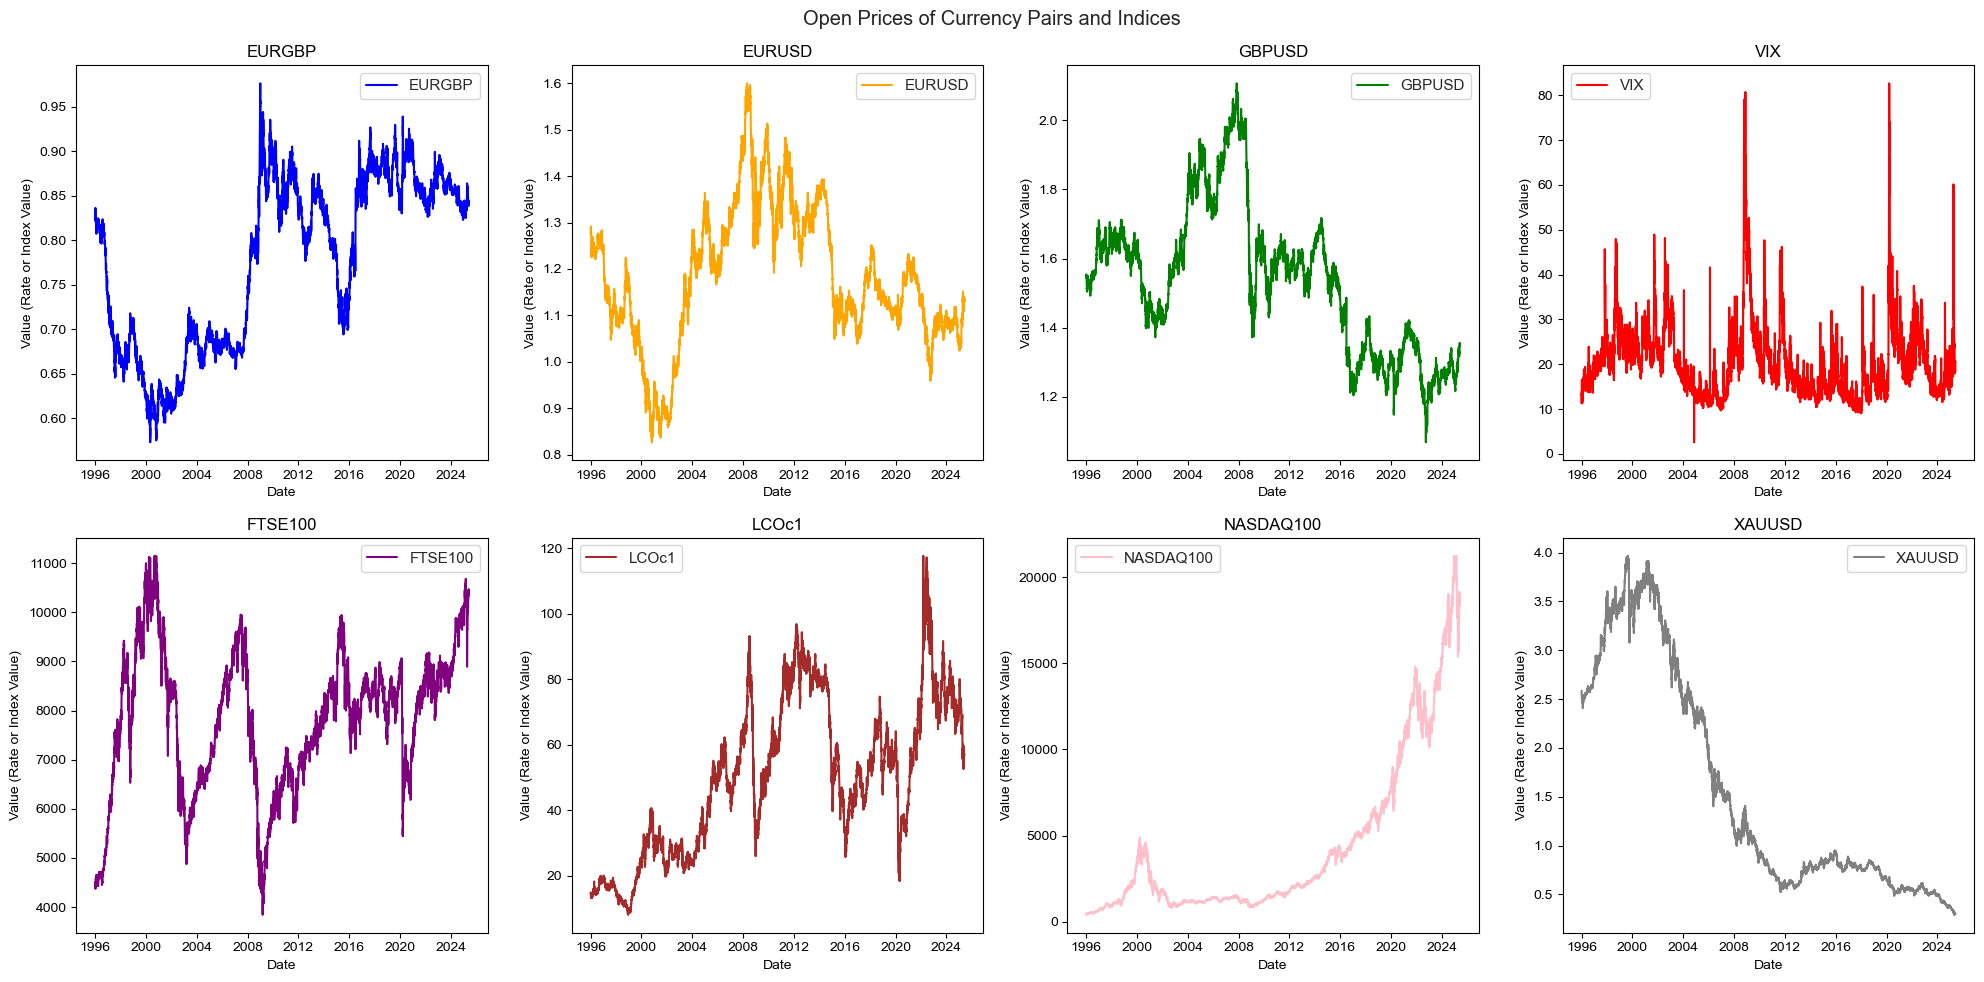

In [ ]:
multi_plot(df,
    title= "Open Prices of Currency Pairs and Indices",
    xlabel="Date",
    ylabel="Value (Rate or Index Value)")

This figure presents eight separate time‐series panels arranged in a 2×4 grid. Each panel plots the daily “Open” price for each of the indeex. All horizontal axes share the same date range (from early 1996 through late May 2025), so you can visually compare how each market evolved in parallel through major events (e.g., the 2008 financial crisis and the 2020 COVID shock).

### Dimension Augmentation
We compute some indicators for the target variable (EURGBP) and the other rates. In particular: Moving Averages (simple and exponential, respectively at 5/10 and 10/20 lookback window), 6/12-month Momentum, Stochastic Momentum Index, Moving Average Convergence Divergence, and Bollinger Band Width.

In [6]:
df = augment_daily_data(df, 'EURGBP_Open')
df = augment_daily_data(df, 'EURUSD_Open')
df = augment_daily_data(df, 'GBPUSD_Open')

In [7]:
print(df.isnull().sum())

EURGBP_Open                    0
EURUSD_Open                    0
XAUUSD_Open                    0
NASDAQ100_Open                 0
FTSE100_Open                   0
LCOc1_Open                     0
GBPUSD_Open                    0
VIX_Open                       0
EURGBP_Open_BOLL_W            19
EURGBP_Open_SMI(StochRSI)      1
EURGBP_Open_MACD              26
EURGBP_Open_EMA10             10
EURGBP_Open_EMA20             20
EURGBP_Open_MA5                5
EURGBP_Open_MA10              10
EURGBP_Open_MTM6             100
EURGBP_Open_MTM12            200
EURUSD_Open_BOLL_W            19
EURUSD_Open_SMI(StochRSI)      1
EURUSD_Open_MACD              26
EURUSD_Open_EMA10             10
EURUSD_Open_EMA20             20
EURUSD_Open_MA5                5
EURUSD_Open_MA10              10
EURUSD_Open_MTM6             100
EURUSD_Open_MTM12            200
GBPUSD_Open_BOLL_W            19
GBPUSD_Open_SMI(StochRSI)      1
GBPUSD_Open_MACD              26
GBPUSD_Open_EMA10             10
GBPUSD_Ope

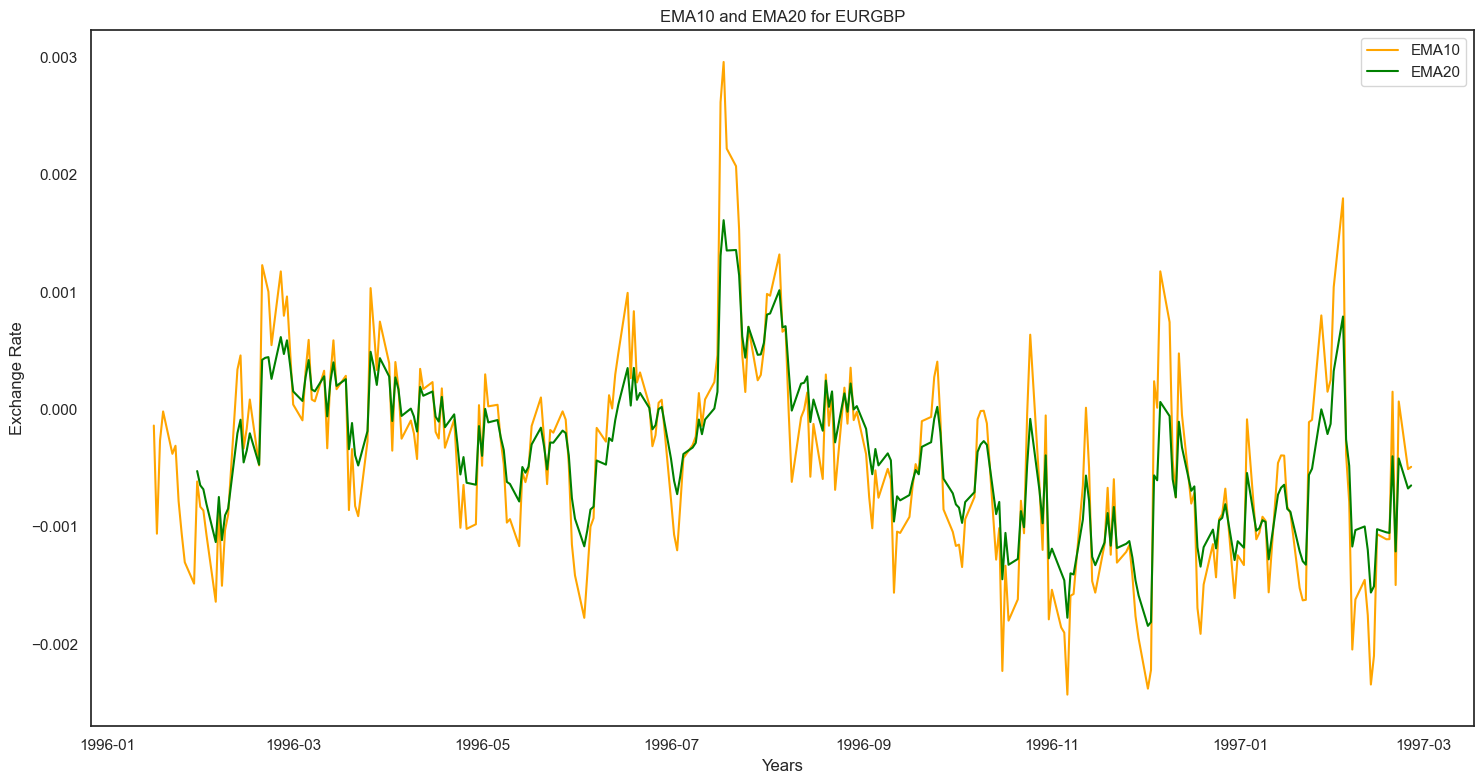

In [8]:
single_plot(df.iloc[:300], 
     data=[df['EURGBP_Open_EMA10'].iloc[:300], df['EURGBP_Open_EMA20'].iloc[:300]],
     labels=['EMA10','EMA20'],
     colors=['orange', 'green'],
     title="EMA10 and EMA20 for EURGBP",
     xlabel="Years",
     ylabel="Exchange Rate",
     figsize=(15, 8))

$\cdot$ EMA10 (orange) = the 10-day exponential moving average of EUR GBP’s daily return (∆ price / price), which gives more weight to the most recent 10 observations.

$\cdot$ EMA20 (green) = the 20-day exponential moving average of that same daily return, smoothing over a longer, slightly more lagged window.

When EMA10 crosses above EMA20, it often suggests that short‐term returns have turned consistently positive faster than the longer window, hinting at building upward momentum.

Conversely, when EMA10 crosses below EMA20, it implies short-term negative returns are outweighing the more gradual trend-an early sign of weakening or downward momentum.

Both lines oscillate around zero, reflecting that EUR GBP’s daily returns are roughly mean‐zero but with occasional bursts.

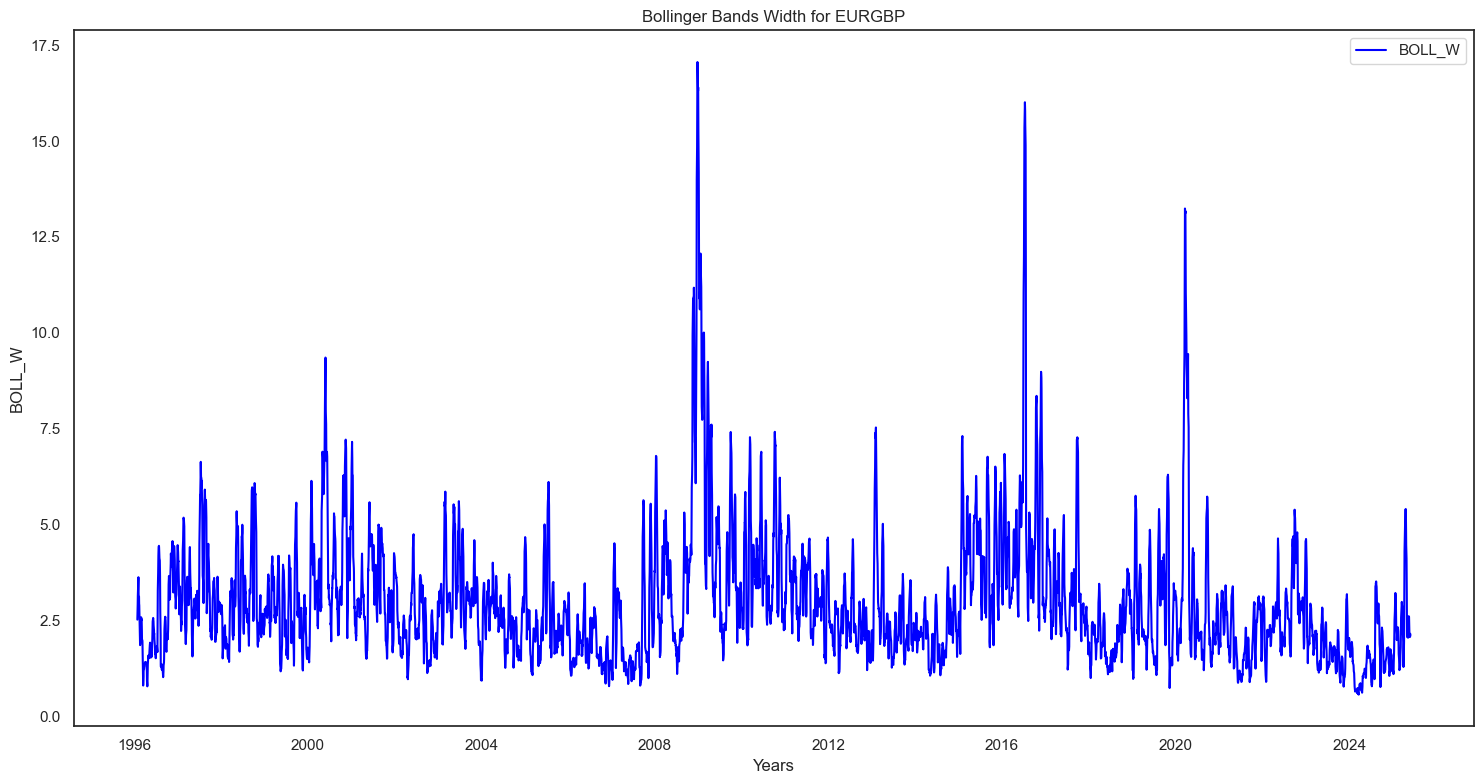

In [9]:
single_plot(df,
        data=[df['EURGBP_Open_BOLL_W']],
        labels=['BOLL_W'],
        colors=['blue'],
        title="Bollinger Bands Width for EURGBP",
        xlabel="Years",
        ylabel="BOLL_W",
        figsize=(15,8))

The Bollinger Bands width plot provides a time‐synchronized, single‐line view of EUR/GBP’s historical volatility. 

When BOLL_W is under ~3, EUR/GBP is in a relatively low‐volatility state. Once it pushes above ~5–6, we know something unusual is happening. 

The tall spikes correspond precisely with the 2008 financial meltdown, the Brexit referendum in 2016, and the COVID outbreak in early 2020. Between those landmark events, the width oscillates in a relatively narrow band, indicating “normal” trading conditions. 

By tracking BOLL_W over time, we can quickly identify when EUR/GBP is about to break out of its usual calm or remain stuck in its typical, low‐volatility regime.

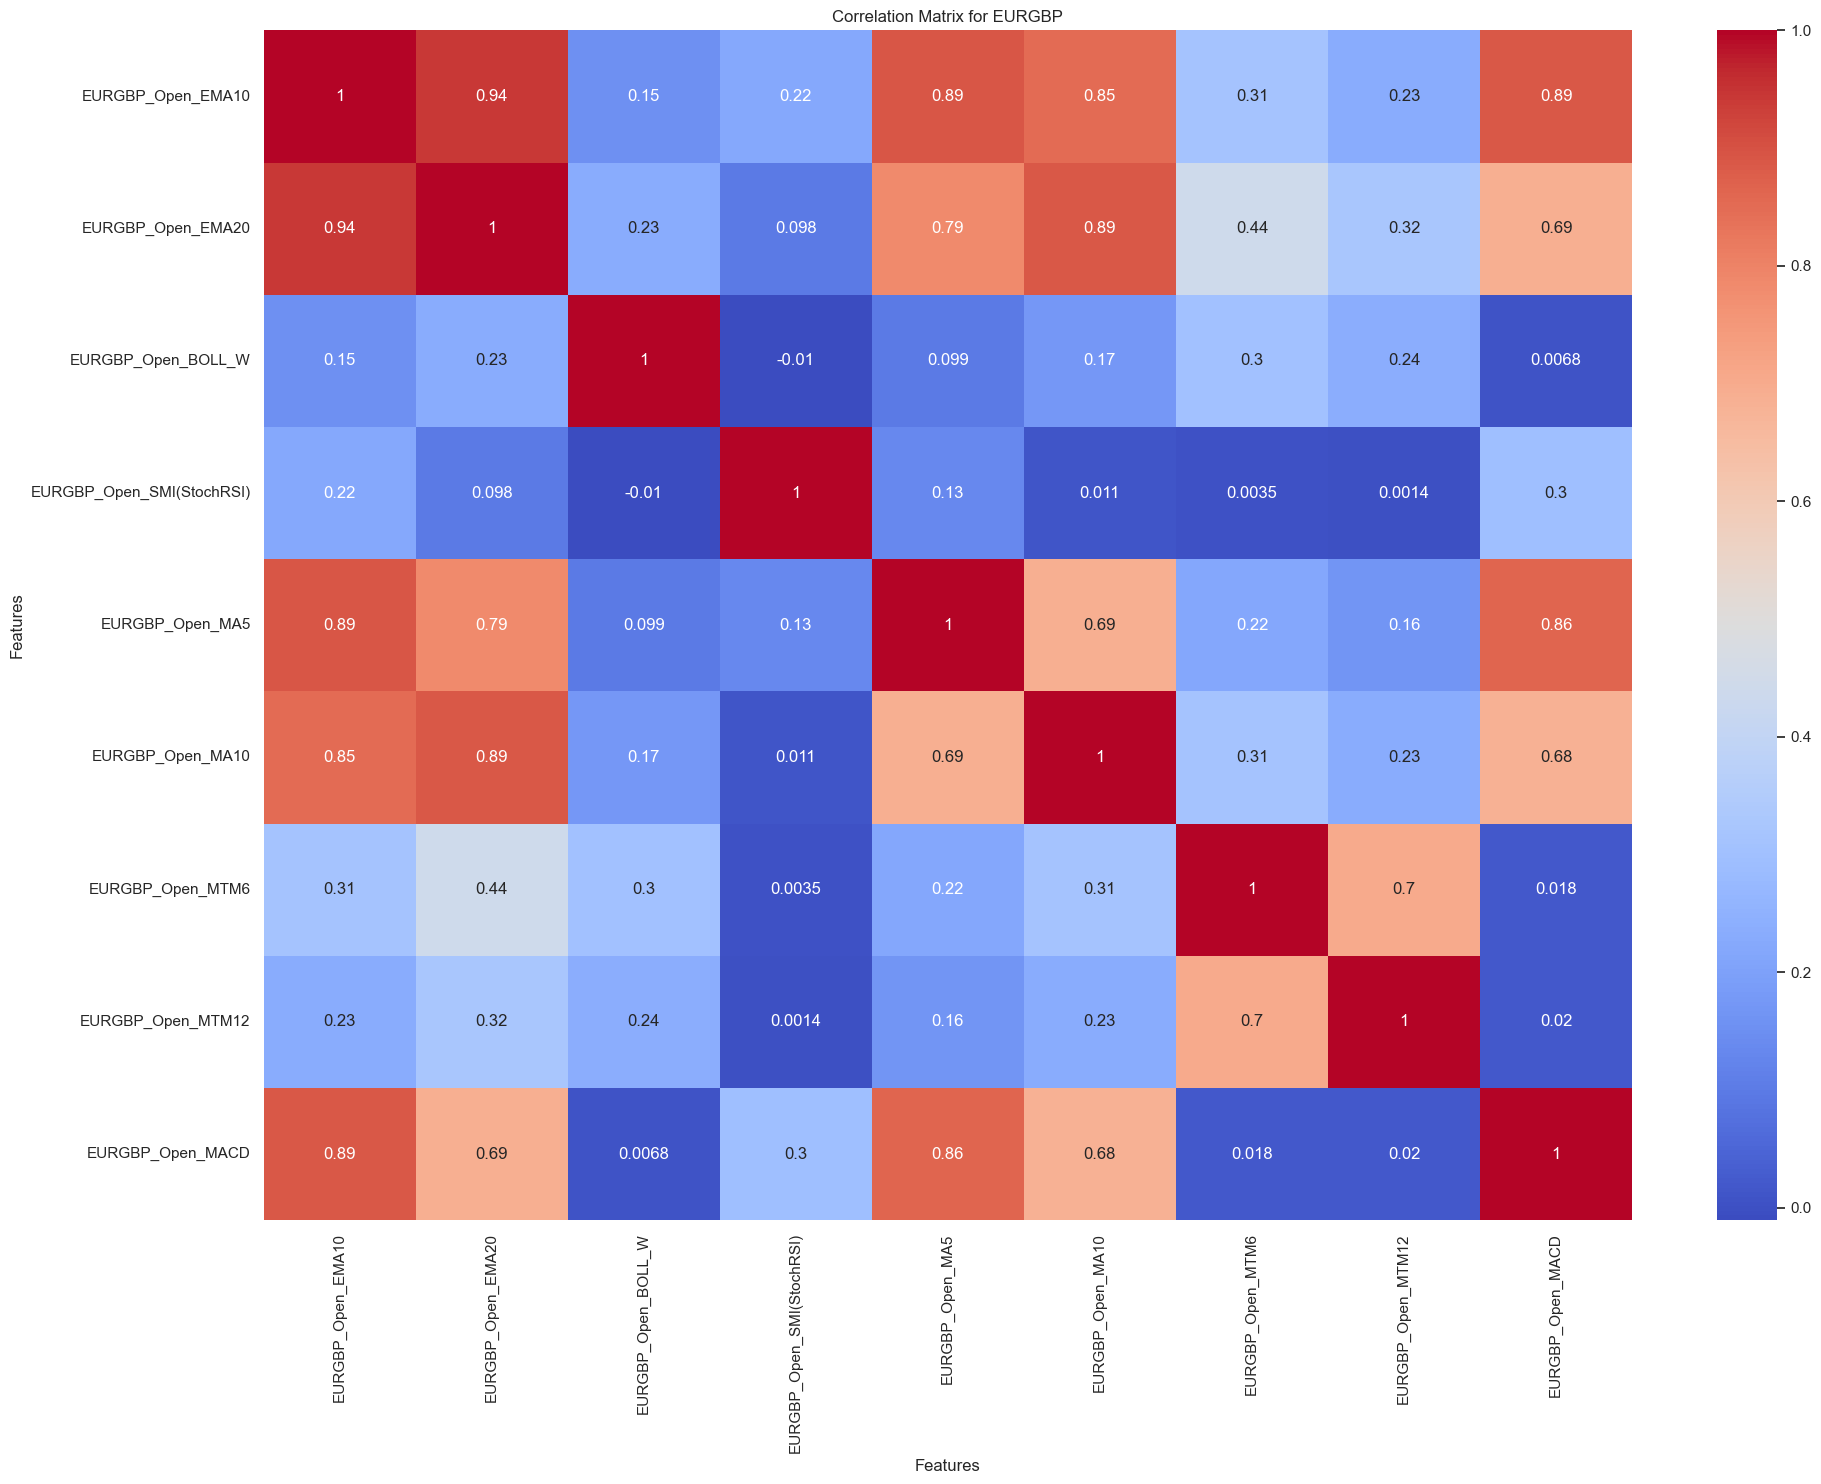

In [ ]:
#Heatmap of the correlation matrix for EURGBP
eurgbp_corr = df[['EURGBP_Open_EMA10', 'EURGBP_Open_EMA20', 
                  'EURGBP_Open_BOLL_W', 'EURGBP_Open_SMI(StochRSI)',
                  'EURGBP_Open_MA5', 'EURGBP_Open_MA10',
                  'EURGBP_Open_MTM6', 'EURGBP_Open_MTM12',
                  'EURGBP_Open_MACD']].corr()
single_plot(eurgbp_corr,
        heatmap=True,
        title="Correlation Matrix for EURGBP",
        xlabel="Features",
        ylabel="Features")


We appreciate some high correlated covariate, but this is expected, since many of them are the output of similar computations from the same initial data. Nontheless, these are still useful for several reasons, some of which we also discussed before (e.g. crosses of MAs).

### First differences

We now take first differences for all covariates. This should mitigate non-stationarity and help to have consistency among train, validation, and test.

In [11]:
df = first_differences_daily_data(df)

df = df.dropna()
df = df*100 # Convert to bps
df

,EURGBP_Open,EURUSD_Open,XAUUSD_Open,NASDAQ100_Open,FTSE100_Open,LCOc1_Open,GBPUSD_Open,VIX_Open,EURGBP_Open_BOLL_W,EURGBP_Open_SMI(StochRSI),...,EURUSD_Open_MTM12,GBPUSD_Open_BOLL_W,GBPUSD_Open_SMI(StochRSI),GBPUSD_Open_MACD,GBPUSD_Open_EMA10,GBPUSD_Open_EMA20,GBPUSD_Open_MA5,GBPUSD_Open_MA10,GBPUSD_Open_MTM6,GBPUSD_Open_MTM12
Exchange Date,,,,,,,,,,,,,,,,,,,,,
1996-10-08,0.290000,0.150001,-0.078887,0.664818,-0.637591,1.994753,-0.119996,1.925635,199.994871,40.130572,...,-2.769995,111.674626,-15.679667,-0.014924,-0.000043,0.019386,-0.045998,0.070001,4.950011,1.630008
1996-10-09,0.029999,0.160003,-0.118124,-1.610208,0.159180,0.360262,-0.010002,2.019536,201.972651,3.876862,...,-2.869999,111.733968,-1.352102,-0.015204,-0.001853,0.016587,-0.023999,-0.022000,4.940009,0.860000
1996-10-10,0.000000,0.189996,-0.078690,0.121284,-0.548482,-1.128203,0.209999,4.278421,201.182243,0.000000,...,-2.339995,109.646895,22.109285,0.002300,0.036665,0.035008,-0.004001,0.035000,5.659997,1.429999
1996-10-11,-0.060004,-0.020003,-0.209433,-0.351810,0.468218,-1.763487,0.099993,-5.082667,202.349524,-5.616884,...,-2.730000,108.860857,10.056763,0.007213,0.048179,0.041197,0.005999,0.043000,5.299997,1.399994
1996-10-14,-0.649995,-0.029993,0.262475,1.791906,0.863278,1.795149,1.330006,-4.709673,224.866237,-47.101631,...,-2.829993,142.800048,9.189513,0.109100,0.281239,0.163940,0.302000,0.166000,6.770003,2.989995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,-0.050002,0.810003,-1.786304,0.000000,0.000000,1.348948,0.810003,3.028798,206.032770,-3.836987,...,3.390002,247.914769,1.027206,0.086394,0.286329,0.191813,0.497999,0.274000,10.810005,5.659997
2025-05-27,-0.070000,0.249994,0.338924,2.223063,-0.170809,0.105083,0.629997,-0.578320,210.719363,-7.741405,...,3.009999,285.280638,0.000000,0.109773,0.348814,0.233545,0.409999,0.390000,10.459995,5.690002
2025-05-28,-0.029999,-0.580001,1.280892,1.502407,0.778413,-0.209934,-0.539994,-6.883180,214.583135,-0.510865,...,2.020001,305.012975,-23.788834,0.033507,0.187213,0.159875,0.230000,0.204000,10.330009,4.790008


We test for stationarity with the Augmented Dickey Fuller (ADF) test, which tests for unit roots in the series.

In [12]:
for col in df.columns:
    temp = '\t'
    adf = adfuller(df[col])
    if adf[1] < 0.05:
        print(f"{col.ljust(30)} is stationary (p-value: {adf[1]:.6f})")
    else:
        print(f"{col.ljust(30)} is not stationary (p-value: {adf[1]:.6f})")
del temp, adf, col

EURGBP_Open                    is stationary (p-value: 0.000000)
EURUSD_Open                    is stationary (p-value: 0.000000)
XAUUSD_Open                    is stationary (p-value: 0.000000)
NASDAQ100_Open                 is stationary (p-value: 0.000000)
FTSE100_Open                   is stationary (p-value: 0.000000)
LCOc1_Open                     is stationary (p-value: 0.000000)
GBPUSD_Open                    is stationary (p-value: 0.000000)
VIX_Open                       is stationary (p-value: 0.000000)
EURGBP_Open_BOLL_W             is stationary (p-value: 0.000000)
EURGBP_Open_SMI(StochRSI)      is stationary (p-value: 0.000000)
EURGBP_Open_MACD               is stationary (p-value: 0.000000)
EURGBP_Open_EMA10              is stationary (p-value: 0.000000)
EURGBP_Open_EMA20              is stationary (p-value: 0.000000)
EURGBP_Open_MA5                is stationary (p-value: 0.000000)
EURGBP_Open_MA10               is stationary (p-value: 0.000000)
EURGBP_Open_MTM6         

All series are stationary.

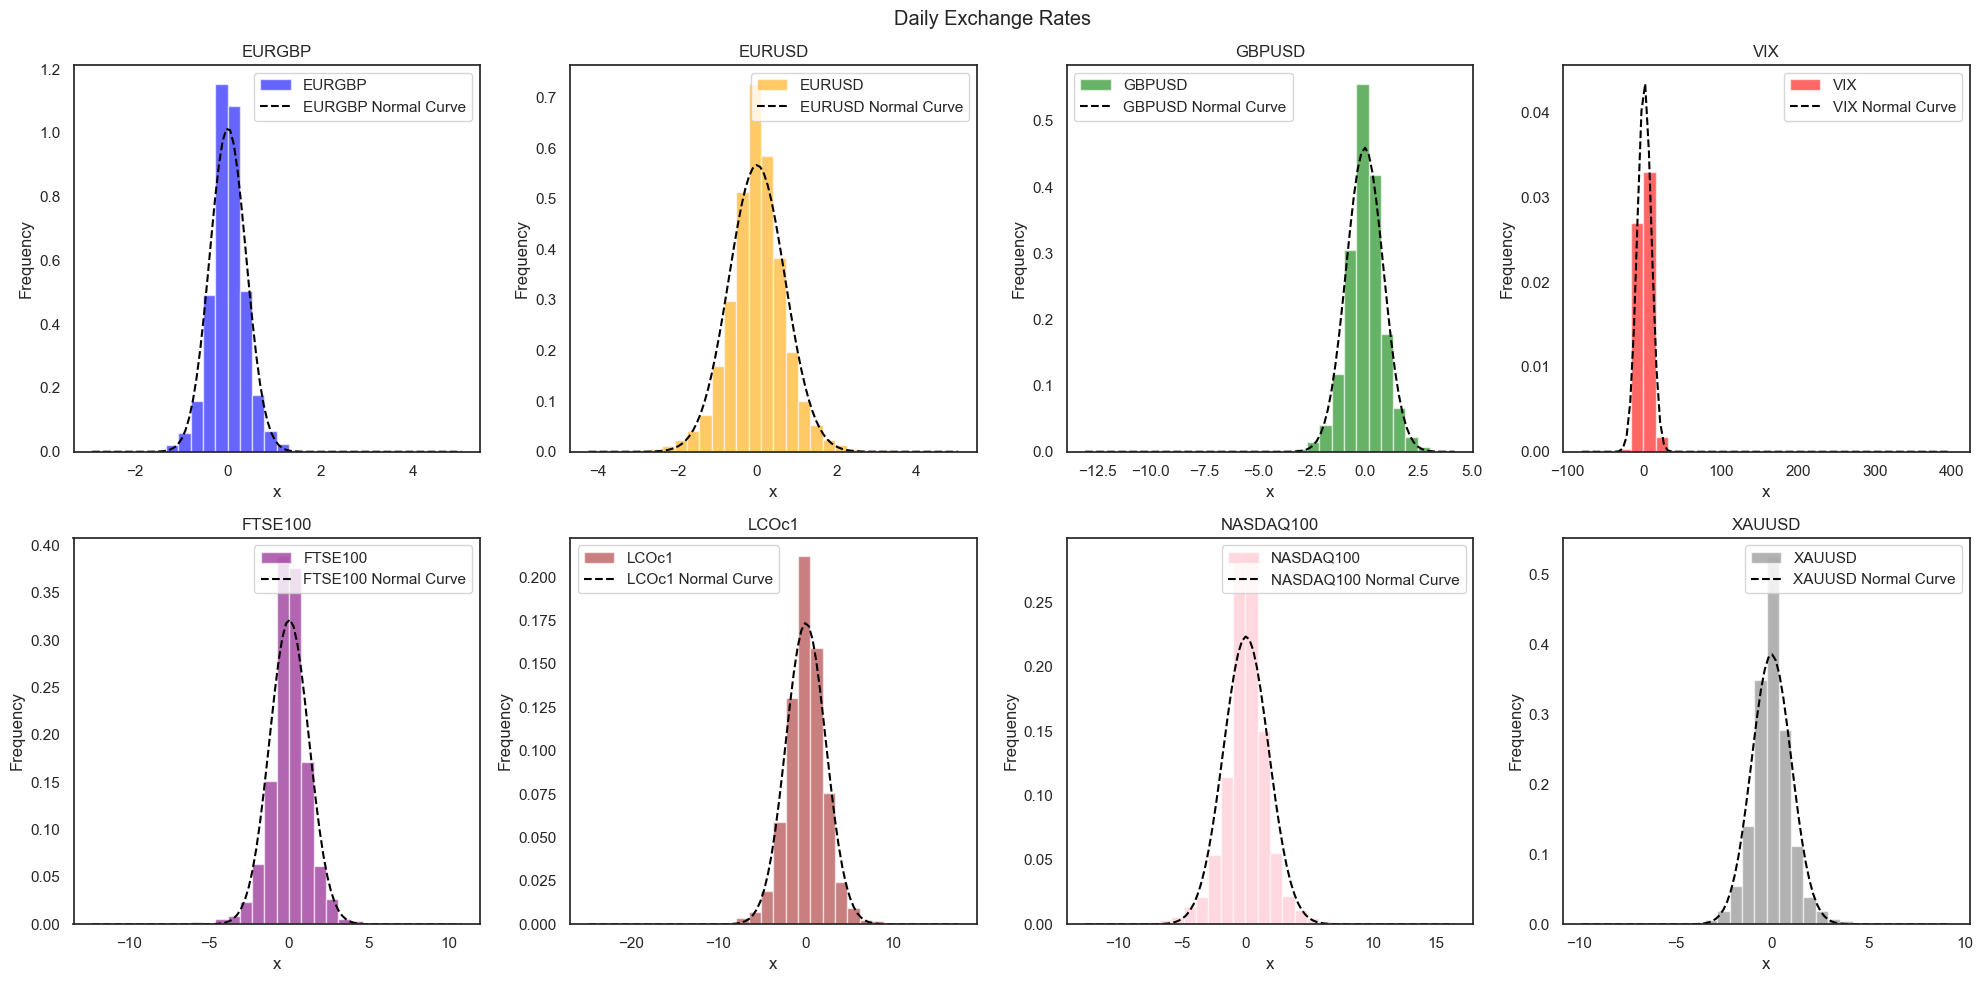

In [19]:
multi_plot(df, 
    title="Daily Exchange Rates",
    xlabel="x",
    ylabel="Frequency",
    plot_type="histogram")

## Split and Standardize 

We split the dataset into train (84%), validation (8%), and test (8%). Even though those are unusual percentages, this is a configuration that keeps volatility similar across sets.

In [20]:
TRAIN_SIZE = 0.84
VAL_SIZE = 0.08
TEST_SIZE = 0.08

train_idx = int(len(df) * TRAIN_SIZE)
val_idx = train_idx + int(len(df) * VAL_SIZE)

df_train = df[:train_idx]
df_val = df[train_idx:val_idx]
df_test = df[val_idx:]

x_train = df_train.drop(columns=['EURGBP_Open']).values
x_val   = df_val.drop(columns=['EURGBP_Open']).values
x_test  = df_test.drop(columns=['EURGBP_Open']).values

y_train = df_train['EURGBP_Open'].values
y_val = df_val['EURGBP_Open'].values
y_test = df_test['EURGBP_Open'].values

PRICE_EURGBP_TRAIN = df_train['EURGBP_Open'].values
PRICE_EURGBP_VAL = df_val['EURGBP_Open'].values
PRICE_EURGBP_TEST = df_test['EURGBP_Open'].values

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

df_val

(6273, 34) (6273,)
(597, 34) (597,)
(599, 34) (599,)


,EURGBP_Open,EURUSD_Open,XAUUSD_Open,NASDAQ100_Open,FTSE100_Open,LCOc1_Open,GBPUSD_Open,VIX_Open,EURGBP_Open_BOLL_W,EURGBP_Open_SMI(StochRSI),...,EURUSD_Open_MTM12,GBPUSD_Open_BOLL_W,GBPUSD_Open_SMI(StochRSI),GBPUSD_Open_MACD,GBPUSD_Open_EMA10,GBPUSD_Open_EMA20,GBPUSD_Open_MA5,GBPUSD_Open_MA10,GBPUSD_Open_MTM6,GBPUSD_Open_MTM12
Exchange Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30,-0.169998,-0.740004,0.522149,0.691533,0.328887,-3.995228,-0.549996,5.180418,129.999110,-14.996682,...,6.190002,208.854978,-15.162047,-0.078978,-0.150417,-0.057288,-0.307999,0.013001,3.300011,-1.929998
2020-11-02,-0.310004,-0.160003,-0.605392,-0.945139,-0.242996,-0.310564,0.169992,-5.488854,145.636185,-12.948832,...,6.369996,207.518912,8.004929,-0.050097,-0.092161,-0.035642,-0.204000,0.030999,4.149997,-1.289999
2020-11-03,0.139999,-0.169992,-0.847822,-0.576335,1.917803,4.423678,-0.309992,-5.522430,152.875892,14.101019,...,6.210005,212.761450,-8.004929,-0.065188,-0.131766,-0.061770,-0.209999,-0.036999,3.100002,-1.399994
2020-11-04,-0.430000,0.740004,-0.741315,4.132473,1.662683,2.118134,1.449990,0.960493,167.106351,-14.101019,...,6.920004,207.611697,60.173706,0.064129,0.155826,0.082207,0.028000,0.115000,4.869998,0.309992
2020-11-05,0.580001,0.099993,0.223482,2.522075,2.034223,1.226997,-0.709999,-25.088341,160.929650,47.277979,...,7.149994,201.414375,-29.696418,-0.007592,-0.001597,0.006759,0.009999,-0.161000,4.330003,-0.310004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-07,-0.360000,-0.629997,-0.192136,0.113678,-0.545949,2.143145,-0.159991,1.612067,282.526982,-23.378776,...,2.260005,385.987399,0.000000,-0.226795,-0.453484,-0.227479,-0.651999,-0.353999,5.900002,-4.689991
2023-02-08,-0.199997,-0.020003,-0.261664,1.776898,0.731206,3.642130,0.199997,-3.377694,291.383781,-12.226289,...,2.100003,412.692878,5.367804,-0.163032,-0.334669,-0.186767,-0.549998,-0.289999,6.680000,-4.569995
2023-02-09,-0.270003,-0.150001,-0.151795,-0.270092,0.430787,0.763941,0.279999,1.906788,293.257359,-23.590405,...,0.879991,428.200617,7.611849,-0.104835,-0.222911,-0.142313,-0.611999,-0.330000,8.029997,-5.509996


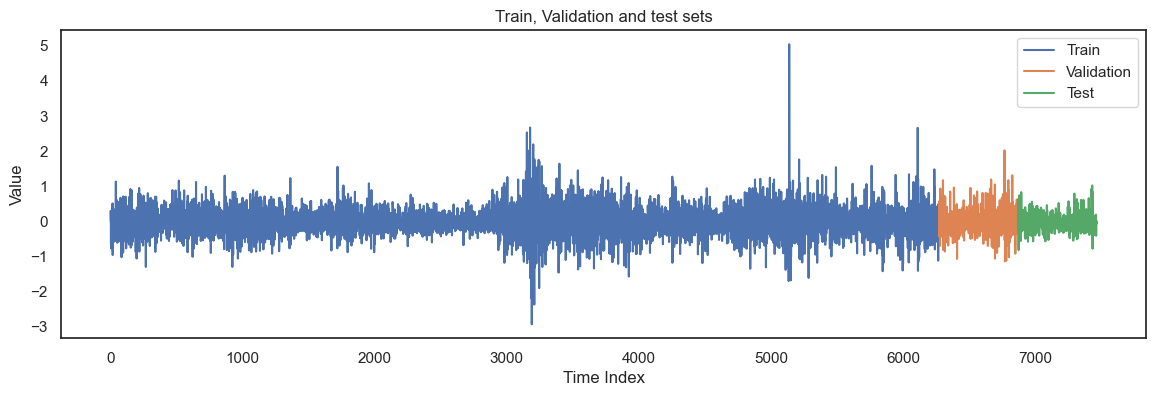

In [15]:
plt.figure(figsize=(14, 4))
plt.plot(np.arange(len(y_train)), y_train, label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='Validation')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, label='Test')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.title('Train, Validation and test sets')
plt.show()

## Data Preprocessing

Now we first scale the data with a common StandardScaler. The, we perform a (discrete) Wavelet Transform (WT) to denoise the series. We ensure that no look-ahead bias is introduced by computing coefficients of the transformation on the train set only.

(This procedure is sometimes not followed even in researches published on journals).

In [16]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape, y_train.shape)

(6273, 34) (6273,)


In [17]:
def wavelet_denoise(x, wavelet='haar', level=1, dec_level=2, no_refitting=False, coeffs=None):
    """
    Denoise a 1D signal using wavelet transform.
    If no_refitting=True, use provided coeffs for thresholding (for validation/test sets).
    Returns: denoised signal, last used coefficients (for reuse)
    """
    n = len(x)
    y = np.zeros(n)
    last_coeffs = None

    for t in range(n):
        past_events = x[:t+1]
        max_lvl = pywt.dwt_max_level(len(past_events), pywt.Wavelet(wavelet).dec_len)
        lvl = min(dec_level, max_lvl)
        if lvl < 1:
            y[t] = past_events[-1]
            continue
        if len(past_events) >= max_lvl:
            try:
                lvl = min(dec_level, max_lvl)
                if not no_refitting or coeffs is None:
                    coeff = pywt.wavedec(past_events, wavelet, level=lvl, mode='sym')
                    sigma = mad(coeff[-level])
                    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
                    denoised_coeff = [coeff[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeff[1:]]
                    last_coeffs = (uthresh, lvl)
                else:
                    uthresh, lvl = coeffs
                    coeff = pywt.wavedec(past_events, wavelet, level=lvl, mode='sym')
                    denoised_coeff = [coeff[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeff[1:]]
                reconstruction = pywt.waverec(denoised_coeff, wavelet=wavelet, mode='sym')
                y[t] = reconstruction[-1]
            except Exception:
                y[t] = past_events[-1]
        else:
            y[t] = past_events[-1]
    return y, last_coeffs

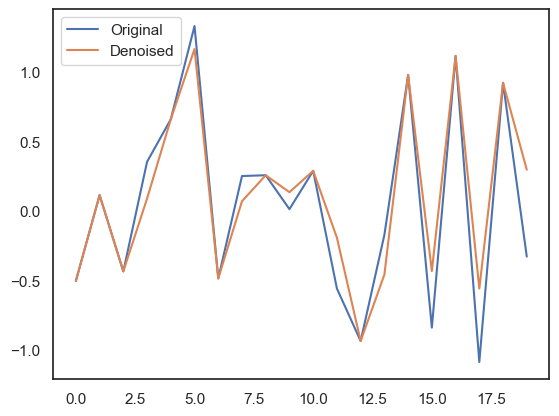

In [18]:
x_train_scaled_wt = x_train_scaled.copy()
x_val_scaled_wt = x_val_scaled.copy()
x_test_scaled_wt = x_test_scaled.copy()

coeffs = [None] * x_train_scaled.shape[1]

for col in range(x_train_scaled.shape[1]):
    x_train_scaled_wt[:, col], coeffs[col] = wavelet_denoise(x_train_scaled[:, col], wavelet='haar', level=1, dec_level=1)

for col in range(x_val_scaled.shape[1]):
    x_val_scaled_wt[:, col], _ = wavelet_denoise(x_val_scaled[:, col], wavelet='haar', level=1, dec_level=1, 
                                              no_refitting=True, coeffs=coeffs[col])

for col in range(x_test_scaled.shape[1]):
    x_test_scaled_wt[:, col], _ = wavelet_denoise(x_test_scaled[:, col], wavelet='haar', level=1, dec_level=1, 
                                               no_refitting=True, coeffs=coeffs[col])

# Example plot of denoised data
plt.plot(x_train_scaled[:20, 3], label='Original')
plt.plot(x_train_scaled_wt[:20, 3], label='Denoised')
plt.legend()

This plot overlays a short segment of the original EUR/GBP returns (in orange) with the wavelet‐denoised version (in blue). You can see that the denoised curve closely tracks the main peaks and valleys of the original data (e.g., at time steps 5, 12, and 18) but has slightly “softened” the small bumps and jagged noise (for instance around steps 2–3 and 9–10). In other words, the wavelet filter removes minor fluctuations while preserving the essential up‐and‐down moves, yielding a cleaner signal that still captures the big swings but without most of the tiny day‐to‐day noise.

## Forecasting

### ARIMA model with GARCH effects

We first fit a standard statistical model to use as baseline for our analysis.

In [21]:
order_selection = arma_order_select_ic(y_train, max_ar=5, max_ma=5, ic=['aic'], trend='n')
best_order = order_selection.aic_min_order
print("Best ARMA order (AIC):", best_order)

/Users/stefano/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/stefano/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/stefano/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefano/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefano/mi

Best ARMA order (AIC): (3, 3)


/Users/stefano/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# Fit ARMA (ARIMA with d=0) with exogenous variables on train set
arma_model = ARIMA(y_train, order=(best_order[0], 0, best_order[1]), exog=x_train_scaled_wt)
arma_res = arma_model.fit()
print(arma_res.summary())
arma_resid = arma_res.resid

# Fit GARCH on ARMA residuals
garch = arch_model(arma_resid, vol='Garch', p=1, q=1)
garch_res = garch.fit(disp='off')
print(garch_res.summary())

# Forecast for val+test using ARMA model (one-step-ahead, using only train fit)
exog_future = np.concatenate([x_val_scaled_wt, x_test_scaled_wt], axis=0)
arma_forecasts = arma_res.forecast(steps=len(exog_future), exog=exog_future)

# Split forecasts
arma_val_forecast = arma_forecasts[:len(y_val)]
arma_test_forecast = arma_forecasts[len(y_val):]

# Forecast GARCH volatility for val+test
garch_vol_forecast = garch_res.forecast(horizon=len(exog_future)).variance.values[-1]
garch_val_vol = garch_vol_forecast[:len(y_val)]
garch_test_vol = garch_vol_forecast[len(y_val):]

/Users/stefano/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6273
Model:                 ARIMA(3, 0, 3)   Log Likelihood                1296.021
Date:                Sun, 01 Jun 2025   AIC                          -2508.041
Time:                        20:57:01   BIC                          -2224.793
Sample:                             0   HQIC                         -2409.898
                               - 6273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.393      0.694      -0.007       0.004
x1             0.5236      0.009     60.354      0.000       0.507       0.541
x2            -0.0073      0.003     -2.158      0.0

/Users/stefano/miniconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
# True one-step-ahead forecasting (no lookahead bias)
y_all = np.concatenate([y_train, y_val, y_test])
x_all = np.concatenate([x_train_scaled_wt, x_val_scaled_wt, x_test_scaled_wt], axis=0)

n_train = len(y_train)
n_val = len(y_val)
n_test = len(y_test)

# Get parameter names and values
param_names = arma_res.param_names
param_values = arma_res.params

# Build a dict for easy lookup
param_dict = dict(zip(param_names, param_values))

# Get AR and MA orders
p, q = best_order

# Get lagged y and exog coefficients
ar_coefs = np.array([param_dict.get(f'ar.L{i}', 0) for i in range(1, p+1)])
ma_coefs = np.array([param_dict.get(f'ma.L{i}', 0) for i in range(1, q+1)])
exog_coefs = np.array([param_dict[k] for k in param_names if k.startswith('x')])
intercept = param_dict.get('const', 0)

# Get residuals from train fit for MA part
resids = list(arma_res.resid[-q:]) if q > 0 else []

# Start from end of train
y_hist = list(y_all[:n_train])
arma_1step_forecasts = []

resids_all = np.array(list(arma_res.resid))
garch_forecast = garch_res.forecast(start=None, horizon=1, reindex=False)

garch_1step_vols = []
current_forecast = garch_forecast

for t in range(n_val + n_test):
    
    ar_part   = np.dot(ar_coefs, y_hist[-p:][::-1]) if p > 0 else 0  # AR
    ma_part   = np.dot(ma_coefs, resids[-q:][::-1]) if q > 0 else 0  # MA
    exog_part = np.dot(exog_coefs, x_all[n_train + t])               # Exogenous part
    
    # Forecast
    yhat = intercept + ar_part + ma_part + exog_part
    arma_1step_forecasts.append(yhat)
    # Update history and residuals with true value
    y_hist.append(y_all[n_train + t])
    resids.append(y_all[n_train + t] - yhat)

    # Get the one-step-ahead forecasted variance
    var_forecast = current_forecast.variance.values[-1, 0]
    garch_1step_vols.append(np.sqrt(var_forecast))
    # Update the forecast with the new residual (from ARMA one-step-ahead)
    new_resid = resids[-1]  # Use the latest residual

# Split forecasts
arma_forecast = arma_1step_forecasts
garch_forecasts = np.array(garch_1step_vols)

y_all_true = np.concatenate([y_val, y_test])

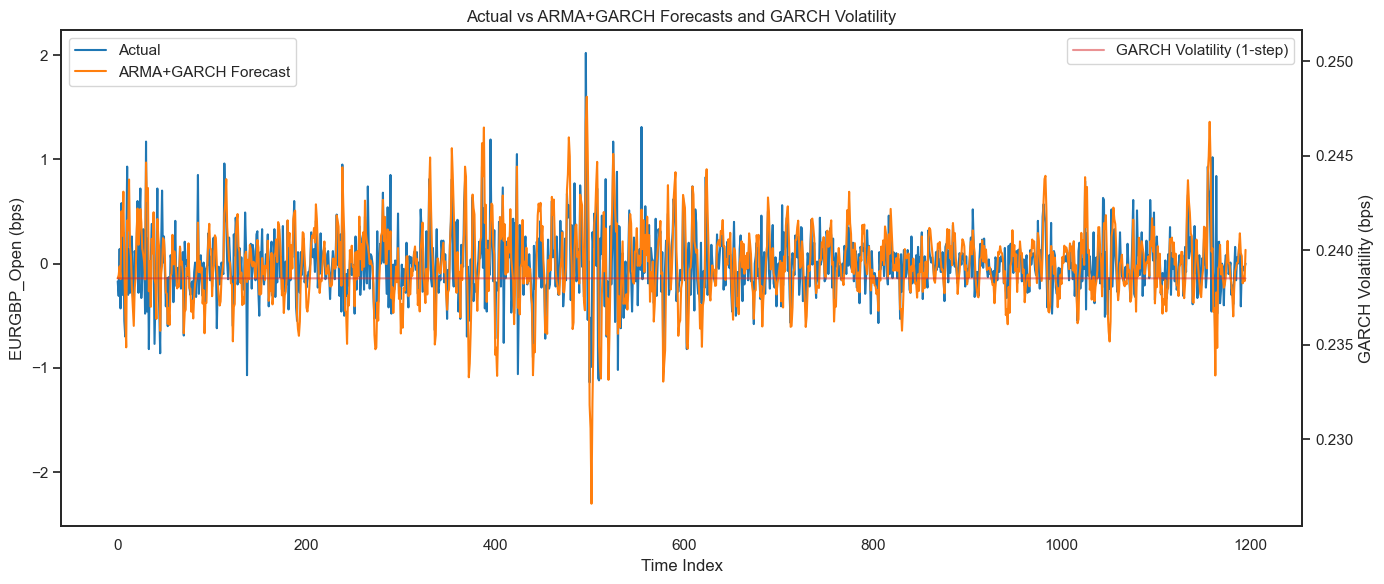

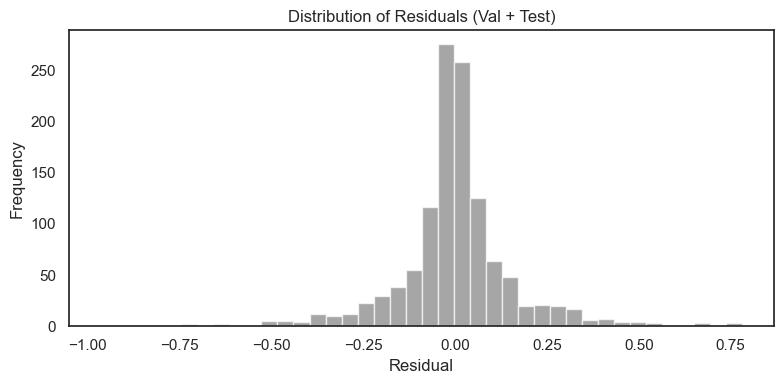

In [26]:
# Actual vs Forecasts + GARCH Volatility

plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax1.plot(np.arange(len(y_all_true)), y_all_true, label='Actual', color='tab:blue')
ax1.plot(np.arange(len(y_all_true)), arma_forecast, label='ARMA+GARCH Forecast', color='tab:orange')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('EURGBP_Open (bps)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(np.arange(len(y_all_true)), garch_forecasts, label='GARCH Volatility (1-step)', color='tab:red', alpha=0.5)
ax2.set_ylabel('GARCH Volatility (bps)')
ax2.legend(loc='upper right')

plt.title('Actual vs ARMA+GARCH Forecasts and GARCH Volatility')
plt.tight_layout()
plt.show()

# Histogram of Residuals
residuals_val = y_val - arma_val_forecast
residuals_test = y_test - arma_test_forecast
plt.figure(figsize=(8, 4))
plt.hist(np.concatenate([residuals_val, residuals_test]), bins=40, color='gray', alpha=0.7)
plt.title('Distribution of Residuals (Val + Test)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [27]:
# Compute metrics

r2 = r2_score(y_all_true, arma_forecast)
print(f"R^2: {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_all_true, arma_forecast))
print(f"RMSE: {rmse:.4f}")

mse = mean_squared_error(y_all_true, arma_forecast)
print(f"MSE: {mse:.4f}")

mae = mean_absolute_error(y_all_true, arma_forecast)
print(f"MAE: {mae:.4f}")

R^2: -0.0075
RMSE: 0.3093
MSE: 0.0957
MAE: 0.2235


$R^2 \sim 0$ (actually slightly negative) means the model does not explain the variance in the data and performs worse than simply predicting the mean.
RMSE (0.3093)/MSE (0.0957) and MAE (0.2235) are relatively high, suggesting substantial prediction errors.

### LSTM - Base model

We now test the forecasting capabilities of a Long-Short Term Memory network.

We first need to create consecutive sequences of our data, which will be fed into the network. We choose $seq\_ len = 20$, which approximately corresponds to a month of trading days.

In [28]:
# Helper function to create sequences
def create_sequences(features: torch.Tensor,
                     targets:  torch.Tensor,
                     seq_len:  int):
    """
    features: (N, D)
    targets:  (N,)  the next-step return at each time
    """
    xs, ys = [], []
    for i in range(len(features) - seq_len):
        x = features[i : i + seq_len]          # seq of D-dimensional features
        y = targets[i + seq_len]               # next-step return
        xs.append(x)
        ys.append(y)
    # stack into tensors
    return torch.stack(xs), torch.stack(ys)

In [29]:
# Split encoded time series into overlapping sequences using a sliding window.

seq_len = 20 # Length of the sequence to create, one trading month.

x_train_lstm, y_train_lstm = create_sequences(torch.from_numpy(x_train_scaled_wt.astype(np.float32)), torch.from_numpy(y_train), seq_len)
x_val_lstm, y_val_lstm = create_sequences(torch.from_numpy(x_val_scaled_wt.astype(np.float32)), torch.from_numpy(y_val), seq_len)
x_test_lstm, y_test_lstm = create_sequences(torch.from_numpy(x_test_scaled_wt.astype(np.float32)), torch.from_numpy(y_test), seq_len)

# Shapes: (batch_size, seq_len, input_dim)
x_train_lstm,    y_train_lstm = x_train_lstm.to(device),   y_train_lstm.to(device)
x_val_lstm,      y_val_lstm   = x_val_lstm.to(device),     y_val_lstm.to(device)
x_test_lstm,     y_test_lstm  = x_test_lstm.to(device),    y_test_lstm.to(device)

print(x_train_lstm.shape, y_train_lstm.shape)

torch.Size([6253, 20, 34]) torch.Size([6253])


#### Baseline LSTM model

First, we 'blindly' create a model to check the base performance. Then, we will create a pipeline to optimize hyperparameters and choose the right architecture.

This model outputs just the best guess of the value of EURGBP for the next trading day.

In [ ]:
hidden_size = 1024
nb_layers   = 2
dropout     = 0.0
input_dim   = x_train_lstm.shape[2]

batch_size  = 512
n_epochs    = 30

# Instantiate three model, optimizer, and loss function
LSTM_plain_model = torch.compile(LSTMRegressor(nb_features=input_dim, hidden_size=hidden_size, 
                                               nb_layers=nb_layers, dropout=dropout, device=device, 
                                               probabilistic=False).to(device))
optimizer_plain  = torch.optim.Adam(LSTM_plain_model.parameters(), lr=1e-4)
loss_fn_plain    = nn.SmoothL1Loss(beta=1.0)

In [15]:
LSTM_plain_model.style

'regression'

In [15]:
# Instantiate DataLoaders for training and validation
train_loader = DataLoader(TensorDataset(x_train_lstm, y_train_lstm),
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=False)

val_loader   = DataLoader(TensorDataset(x_val_lstm, y_val_lstm),
                          batch_size=batch_size,
                          shuffle=False,
                          pin_memory=False)

# Train the model
train_loss_series, val_loss_series = train_LSTM(LSTM_plain_model, train_loader, val_loader, loss_fn_plain, optimizer_plain, n_epochs=n_epochs)

Training on cuda:0
Epoch 1/30 — Train loss: 0.07885502 | Val loss: 0.06429964
Epoch 2/30 — Train loss: 0.07809425 | Val loss: 0.06402258
Epoch 3/30 — Train loss: 0.07757438 | Val loss: 0.06358940
Epoch 4/30 — Train loss: 0.07661810 | Val loss: 0.06274448
Epoch 5/30 — Train loss: 0.07506058 | Val loss: 0.06188631
Epoch 6/30 — Train loss: 0.07304460 | Val loss: 0.05961636
Epoch 7/30 — Train loss: 0.07075092 | Val loss: 0.05821262
Epoch 8/30 — Train loss: 0.06868622 | Val loss: 0.05697796
Epoch 9/30 — Train loss: 0.06695459 | Val loss: 0.05563136
Epoch 10/30 — Train loss: 0.06615107 | Val loss: 0.05474253
Epoch 11/30 — Train loss: 0.06539863 | Val loss: 0.05466415
Epoch 12/30 — Train loss: 0.06501722 | Val loss: 0.05423049
Epoch 13/30 — Train loss: 0.06431798 | Val loss: 0.05477542
Epoch 14/30 — Train loss: 0.06372802 | Val loss: 0.05407089
Epoch 15/30 — Train loss: 0.06320542 | Val loss: 0.05442316
Epoch 16/30 — Train loss: 0.06255023 | Val loss: 0.05405926
Epoch 17/30 — Train loss: 0.06

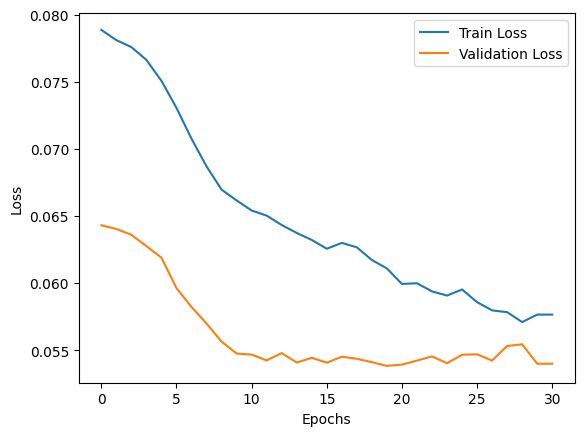

In [16]:
plt.plot(train_loss_series, label='Train Loss')
plt.plot(val_loss_series, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [17]:
# Compute LSTM predictions on the test sequences
LSTM_plain_model.eval()
with torch.no_grad():
    if LSTM_plain_model.style =='probabilistic':
        preds_test, var_test = LSTM_plain_model(x_test_lstm)
    else:
        preds_test = LSTM_plain_model(x_test_lstm)

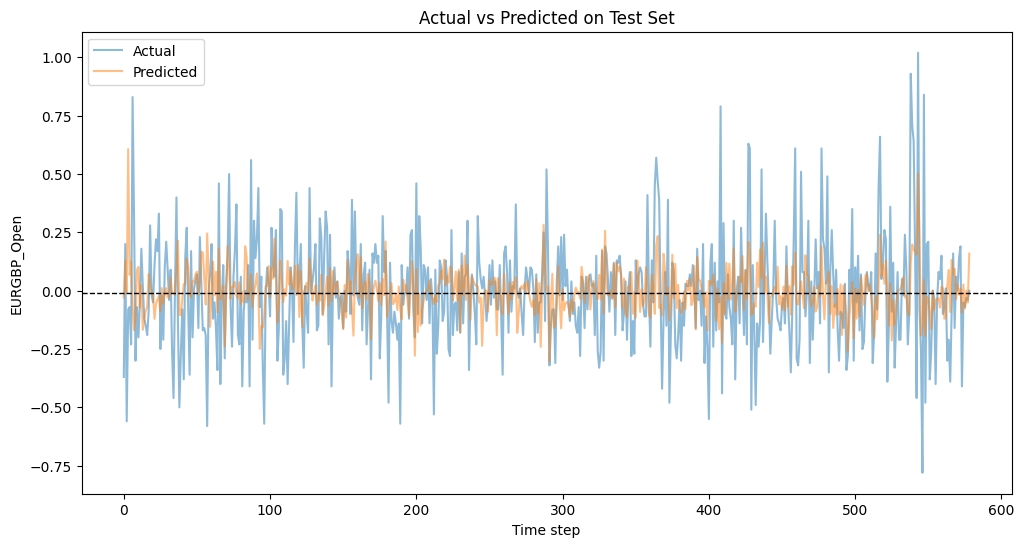

In [ ]:
# Convert to numpy
y_pred = preds_test.cpu().numpy()
y_true = y_test_lstm.cpu().numpy()
if LSTM_plain_model.style == 'probabilistic':
    # If the model is probabilistic, we also have variance predictions
    var_pred = var_test.cpu().numpy()

if LSTM_plain_model.style == 'probabilistic':
        
    # Plot actual vs. predicted with variance
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:100], label='Actual', alpha=0.7)
    plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
    plt.fill_between(np.arange(len(y_pred[:100])),
                    y_pred[:100] - np.sqrt(var_pred[:100]),
                    y_pred[:100] + np.sqrt(var_pred[:100]),
                    color='gray', alpha=0.3, label='Predicted ±1 std')
    plt.axhline(y=y_test[:20].mean(), color='k', linestyle='--', lw=1)
    plt.xlabel('Time step')
    plt.ylabel('EURGBP_Open')
    plt.title('Actual vs Predicted on Test Set')
    plt.legend()
    plt.show()
else:
    # Plot actual vs. predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.axhline(y=y_test.mean(), color='k', linestyle='--', lw=1)
    plt.xlabel('Time step')
    plt.ylabel('EURGBP_Open')
    plt.title('Actual vs Predicted on Test Set')
    plt.legend()
    plt.show()

In [ ]:
print(f'Predictions: \t mean: {y_pred.mean():.4f}, std: {y_pred.std():.4f}, min: {y_pred.min():.4f}, max: {y_pred.max():.4f}')
print(f'Actual values: \t mean: {y_true.mean():.4f}, std: {y_true.std():.4f}, min: {y_true.min():.4f}, max: {y_true.max():.4f}')

mae = np.mean(np.abs(y_pred - y_true))
print(f"Test MAE: {mae:.6f}")
mse = np.mean((y_pred - y_true) ** 2)
print(f"Test MSE: {mse:.6f}")
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.6f}")
r2 = r2_score(y_true, y_pred)
print(f"Test R2: {r2:.6f}")

del mae, mse, rmse, r2

Predictions: 	 mean: -0.0017, std: 0.0973, min: -0.3013, max: 0.6070
Actual values: 	 mean: -0.0079, std: 0.2351, min: -0.7800, max: 1.0200
Test MAE: 0.165297
Test MSE: 0.047798
Test RMSE: 0.218627
Test R2: 0.135301


### Hyperparameter Tuning - LSTM Model

 Now we will tune hyperparameters for two types of LSTM architectures.
 
 The first architecture outputs only a point estimate (the best guess) for the next value. The second architecture outputs both a mean and a variance, which can be interpreted as a confidence interval for the next-day prediction. To enable this, we modified the fully connected layer in LSTMModel.py so that it can output two values instead of one.

In [26]:
from sklearn.model_selection import ParameterGrid

best_models = []

# Define hyperparameter grid
regression_style = ['standard', 'probabilistic']
param_grid = {
    'hidden_size': [512, 1024, 2048],
    'nb_layers': [1, 2, 4],
    'dropout': [0.1],
    'lr': [1e-4],
    'batch_size': [256, 512],
    'n_epochs': [60]
}

best_val_loss = float('inf')
best_params = None
input_dim = x_train_lstm.shape[2]

for style in regression_style:
    if style == 'standard':
        loss_fn = nn.SmoothL1Loss(beta=1.0)
    elif style == 'probabilistic':
        loss_fn = nn.GaussianNLLLoss()
    
    print(f"\n ######### Testing regression style: {style} --- Loss function: {loss_fn.__class__.__name__} ######### \n")

    for params in ParameterGrid(param_grid):
        print(f"Testing params: {params}")
        # Re-instantiate model and optimizer for each run
        model = torch.compile(LSTMRegressor(
            nb_features=input_dim,
            hidden_size=params['hidden_size'],
            nb_layers=params['nb_layers'],
            dropout=params['dropout'],
            device=device,
            probabilistic=(style == 'probabilistic')
        ).to(device))

        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

        # DataLoaders
        train_loader = DataLoader(TensorDataset(x_train_lstm, y_train_lstm),
                                batch_size=params['batch_size'],
                                shuffle=True,
                                pin_memory=False)
        val_loader   = DataLoader(TensorDataset(x_val_lstm, y_val_lstm),
                                batch_size=params['batch_size'],
                                shuffle=False,
                                pin_memory=False)

        # Train for a small number of epochs for speed
        train_loss_series, val_loss_series = train_LSTM(model, train_loader, val_loader, loss_fn, 
                                                        optimizer, n_epochs=params['n_epochs'], verbose=False)
        val_loss = val_loss_series[-1]
        print(f"Validation loss: {val_loss:.6f} \n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
        
    best_models.append({
        'regression_type': style,
        'model': best_model,
        'val_series': val_loss_series,
        'train_series': train_loss_series,
        'best_params': best_params,
    })

    print(f"\nBest hyperparameters: {best_params}")
    print(f"Best validation loss: {best_val_loss:.6f}")


 ######### Testing regression style: standard --- Loss function: SmoothL1Loss ######### 

Testing params: {'batch_size': 256, 'dropout': 0.1, 'hidden_size': 512, 'lr': 0.0001, 'n_epochs': 60, 'nb_layers': 1}
Training on cuda:0
Epoch 1/60 — Train loss: 0.07818306 | Val loss: 0.06317137
Epoch 20/60 — Train loss: 0.06062792 | Val loss: 0.05419822
Epoch 40/60 — Train loss: 0.05171389 | Val loss: 0.05487706
Epoch 60/60 — Train loss: 0.04321961 | Val loss: 0.06088056
Restored best model weights (val loss: 0.05387652)
Validation loss: 0.060881 

Testing params: {'batch_size': 256, 'dropout': 0.1, 'hidden_size': 512, 'lr': 0.0001, 'n_epochs': 60, 'nb_layers': 2}
Training on cuda:0
Epoch 1/60 — Train loss: 0.07883867 | Val loss: 0.06428370
Epoch 20/60 — Train loss: 0.06064785 | Val loss: 0.05372995
Epoch 40/60 — Train loss: 0.05346071 | Val loss: 0.05483199
Epoch 60/60 — Train loss: 0.04764620 | Val loss: 0.05532778
Restored best model weights (val loss: 0.05372995)
Validation loss: 0.055328 


In [28]:
print(best_models)

[{'regression_type': 'standard', 'model': OptimizedModule(
  (_orig_mod): LSTMRegressor(
    (lstm): LSTM(34, 1024, num_layers=2, batch_first=True, dropout=0.1)
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=1, bias=True)
    )
  )
), 'val_series': [0.06458112556145137, 0.0645539159636357, 0.06451770200344058, 0.06445747545469985, 0.06444343806371945, 0.06440515597342825, 0.06417037857183137, 0.06064801233170144, 0.056418327211145716, 0.055493273428500835, 0.05438762798621295, 0.05553843669167218, 0.055016329405470986, 0.05517010458549759, 0.05474245936272462, 0.05495946346887063, 0.054859062827852405, 0.05461790671562405, 0.05476119646244074, 0.05425413849681254, 0.05488217507765033, 0.05533614966443754, 0.05547553005158591, 0.05511395614497377, 0.05469509368468612, 0.054515861762458366, 0.05475183472398869, 0.05702768459244659, 0.05546325117194673, 0.05706120877

In [ ]:
# Save the best models
for i, model_info in enumerate(best_models):
    model = model_info['model']
    regression_type = model_info['regression_type']
    fname = f'LSTM_daily_best_{regression_type}_Model_state_{model.lstm.hidden_size}x{model.lstm.num_layers}.pth'
    os.makedirs('model_params', exist_ok=True)
    torch.save(model.state_dict(), os.path.join('model_params', fname))
    print(f"Model state dict for {regression_type} saved to lstm_LSTM_{regression_type}_Model_state_{model.lstm.hidden_size}x{model.lstm.num_layers}.pth")

In [ ]:
# Load the trained LSTM models
input_dim = x_train_lstm.shape[2]

def load_lstm_model(model_path, input_dim, hidden_size, nb_layers, prob, device):
    model = LSTMRegressor(nb_features=input_dim, hidden_size=hidden_size, nb_layers=nb_layers, dropout=0.1, 
                          device=device, probabilistic=prob).to(device)
    state_dict = torch.load(model_path, map_location=device)
    # Remove _orig_mod. prefix if present
    new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

lstm_standard_model = load_lstm_model('model_params/lstm_LSTM_standard_Model_state_1024x2.pth', input_dim, 1024, 2, False, device)
lstm_standard_model = torch.compile(lstm_standard_model)
lstm_probabilistic_model = load_lstm_model('model_params/lstm_LSTM_probabilistic_Model_state_512x1.pth', input_dim, 512, 1, True, device)
lstm_probabilistic_model = torch.compile(lstm_probabilistic_model)

models = [lstm_standard_model, lstm_probabilistic_model]

/Users/stefano/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


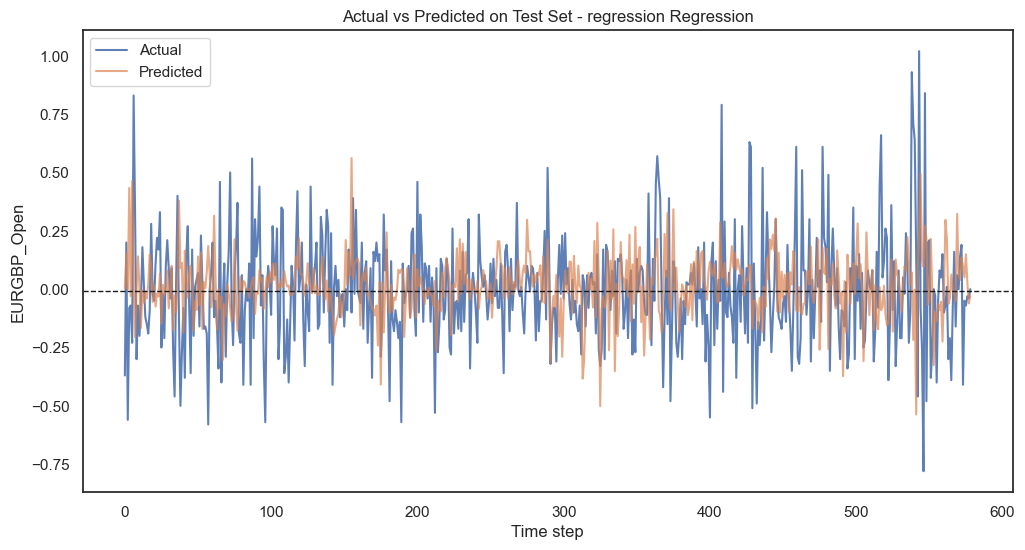

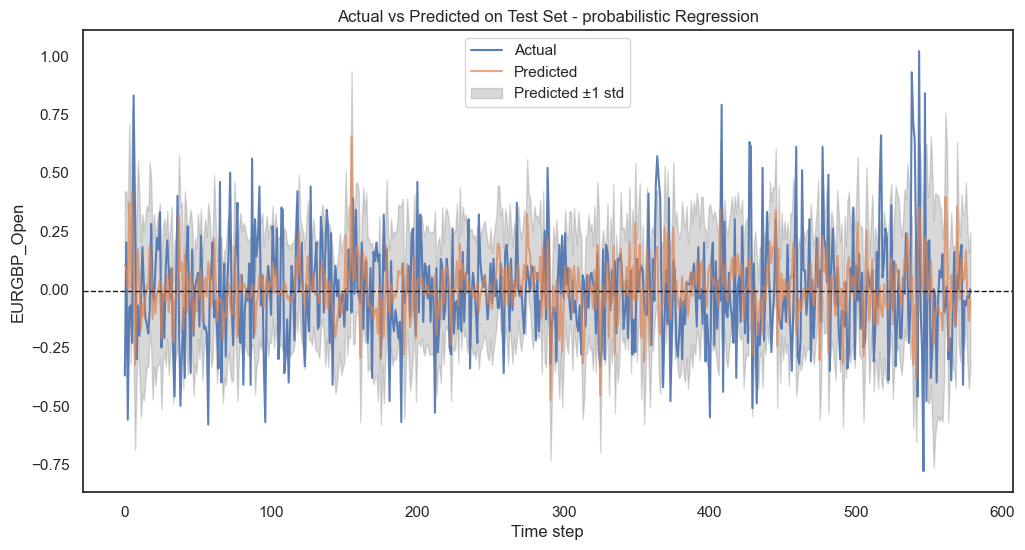

In [40]:
# Plot test predictions for the best models
for model in models:
    regression_type = model.style
    
    # Compute predictions on the test sequences
    model.eval()
    with torch.no_grad():
        if model.style == 'probabilistic':
            preds_test, var_test = model(x_test_lstm)
        else:
            preds_test = model(x_test_lstm)

    # Convert to numpy
    y_pred = preds_test.cpu().numpy()
    y_true = y_test_lstm.cpu().numpy()
    if model.style == 'probabilistic':
        var_pred = var_test.cpu().numpy()

    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', alpha=0.9)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    if model.style == 'probabilistic':
        plt.fill_between(np.arange(len(y_pred)),
                        y_pred - np.sqrt(var_pred),
                        y_pred + np.sqrt(var_pred),
                        color='gray', alpha=0.3, label='Predicted ±1 std')
    plt.axhline(y=y_test.mean(), color='k', linestyle='--', lw=1)
    plt.xlabel('Time step')
    plt.ylabel('EURGBP_Open')
    plt.title(f'Actual vs Predicted on Test Set - {model.style} Regression')
    plt.legend()
    plt.show()

In [ ]:
# Compute and print metrics for both models

metrics = []
for model in models:
    regression_type = model.style
    model.eval()
    with torch.no_grad():
        if model.style == 'probabilistic':
            preds_test, _ = model(x_test_lstm)
        else:
            preds_test = model(x_test_lstm)
    y_pred = preds_test.cpu().numpy()
    y_true = y_test_lstm.cpu().numpy()

    mae = np.mean(np.abs(y_pred - y_true))
    mse = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    metrics.append([
        regression_type,
        f"{y_pred.mean():.4f}",
        f"{y_pred.std():.4f}",
        f"{y_pred.min():.4f}",
        f"{y_pred.max():.4f}",
        f"{mae:.6f}",
        f"{mse:.6f}",
        f"{rmse:.6f}",
        f"{r2:.6f}"
    ])

headers = [
    "Model", "Pred Mean", "Pred Std", "Pred Min", "Pred Max",
    "MAE", "MSE", "RMSE", "R2"
]
print(tabulate(metrics, headers=headers, tablefmt="fancy_grid"))

We evaluated the two LSTM architectures for one-step-ahead forecasting:

  Both models track the actual EURGBP movements reasonably well. However, the probabilistic model's predictions tend to be smoother and less prone to extreme deviations. The shaded area in the probabilistic model's plot represents the predicted ±1 standard deviation, giving a visual sense of forecast uncertainty.

#### Interpretation

- **Accuracy:**  
  The probabilistic model achieves slightly lower MAE and RMSE, and a higher R², indicating better overall predictive performance.

- **Uncertainty Quantification:**  
  The probabilistic model provides not only a point forecast but also an estimate of uncertainty, which is valuable for risk management and decision-making.

- **Conclusion:**  
  While both models perform well, the probabilistic LSTM offers a modest but consistent improvement in accuracy and provides useful uncertainty estimates. For applications where understanding prediction confidence is important, the probabilistic approach is preferable.

## Trading strategy

We now implement a simple trading strategy using the predictions from both the **standard** and **probabilistic** LSTM models.

The strategy takes a position when the model's predicted return is sufficiently large (greater than ±0.1 bps), and, for the probabilistic model, also only when the predicted uncertainty (standard deviation) is below its historical mean (comouted on the train set). We include a 2-bips transaction cost for every trade executed.

In [76]:
model_prob = best_models[1]['model']
model_standard = best_models[0]['model']
dates = df_test.index[1:]

In [ ]:
def calculate_pnl(model, x_train_lstm, x_test_lstm):
    model.eval()
    with torch.no_grad():
        if model.style == 'probabilistic':
            y_pred, var_pred  = model(x_test_lstm)
            _, var_pred_train = model(x_train_lstm)
        else:
            y_pred = model(x_test_lstm)
            var_pred = None
            var_pred_train = None

    if model.style == 'probabilistic':
        var_pred = var_pred.detach().cpu().numpy()
        std_pred = np.sqrt(var_pred)

        # Compute mean std on the train set, not the test set
        std_pred_train = np.sqrt(var_pred_train.detach().cpu().numpy())
        mean_std = np.mean(std_pred_train)

        plt.plot(var_pred, label='Predicted Volatility')
        plt.plot(std_pred, label='Predicted Std Dev')
        print(f"Mean Std Dev: {mean_std:.3f}")
        plt.axhline(mean_std, linestyle='--', label=f'Mean Std: {mean_std:.3f}')
        plt.legend()

        pnl = []
        num_trades = 0
        for i in range(1, len(y_pred)):
            if std_pred[i] < mean_std:
                if y_pred[i] > 0.1:
                    pnl_change = PRICE_EURGBP_TEST[i] - PRICE_EURGBP_TEST[i-1] - 0.0002
                    num_trades += 1
                elif y_pred[i] < -0.1:
                    pnl_change = PRICE_EURGBP_TEST[i-1] - PRICE_EURGBP_TEST[i] - 0.0002 # 1 bps transaction cost
                    num_trades += 1
                else:
                    pnl_change = 0.0
            else:
                pnl_change = 0.0
            pnl.append(pnl_change)

        pnl = np.array(pnl)
    
    else:
        pnl = []
        num_trades = 0
        for i in range(1, len(y_pred)):
            if y_pred[i] > 0.1:
                pnl_change = PRICE_EURGBP_TEST[i] - PRICE_EURGBP_TEST[i-1] - 0.0002
                num_trades += 1
            elif y_pred[i] < -0.1:
                pnl_change = PRICE_EURGBP_TEST[i-1] - PRICE_EURGBP_TEST[i] - 0.0002 # 1 bps transaction cost
                num_trades += 1
            else:
                pnl_change = 0.0
            pnl.append(pnl_change)

        pnl = np.array(pnl)

    # Compute Sharpe ratio and annualized Sharpe ratio
    sharpe_ratio = np.mean(pnl) / np.std(pnl) if np.std(pnl) > 0 else np.nan
    # Assuming 252 trading days per year, and pnl is per day
    annualized_sharpe = sharpe_ratio * np.sqrt(252)
    print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe:.3f} \n")
    print(f" mean PnL: {np.mean(pnl):.3f} \n std PnL: {np.std(pnl):.3f} \n min PnL: {np.min(pnl):.3f} \n max PnL: {np.max(pnl):.3f}")

    # Calculate cumulative PnL
    cumulative_pnl = np.cumsum(pnl)
    print(f"Total PnL: {cumulative_pnl[-1]:.3f} \n - Number of trades: \t {num_trades} \n "
        f"- Avg PnL per trade: \t {cumulative_pnl[-1]/num_trades:.3f} \n - Win rate: \t\t {np.sum(pnl > 0) / num_trades:.3%} \n "
        f"- Average win: \t {np.mean(pnl[pnl > 0]):.3f} \n - Average loss: \t {np.mean(pnl[pnl < 0]):.3f}")
    
    return cumulative_pnl

In [80]:
def plot_cumulative_pnl(cumulative_pnl, dates):
    """
    Plot cumulative PnL over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_pnl, label='Cumulative PnL', color='blue')
    #plt.plot(y_true, label='Actual EURGBP_Open', color='orange', alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='--', lw=1)
    plt.xlabel('Time step')

    # Only show xticks at the start of each month
    month_starts = [i for i, d in enumerate(dates) if (i == 0) or (str(d)[:7] != str(dates[i-1])[:7])]
    plt.xticks(ticks=month_starts, labels=[str(dates[i])[:10] for i in month_starts], rotation=45)

    plt.ylabel('Cumulative PnL')
    plt.title('Cumulative PnL from LSTM Predictions')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.gca().set_facecolor('white')
    plt.show()

Sharpe Ratio: -0.007
Annualized Sharpe Ratio: -0.112 

 mean PnL: -0.001 
 std PnL: 0.159 
 min PnL: -0.720 
 max PnL: 0.970
Total PnL: -0.648 
 - Number of trades: 	 141 
 - Avg PnL per trade: 	 -0.005 
 - Win rate: 		 43.262% 
 - Average win: 	 0.282 
 - Average loss: 	 -0.223


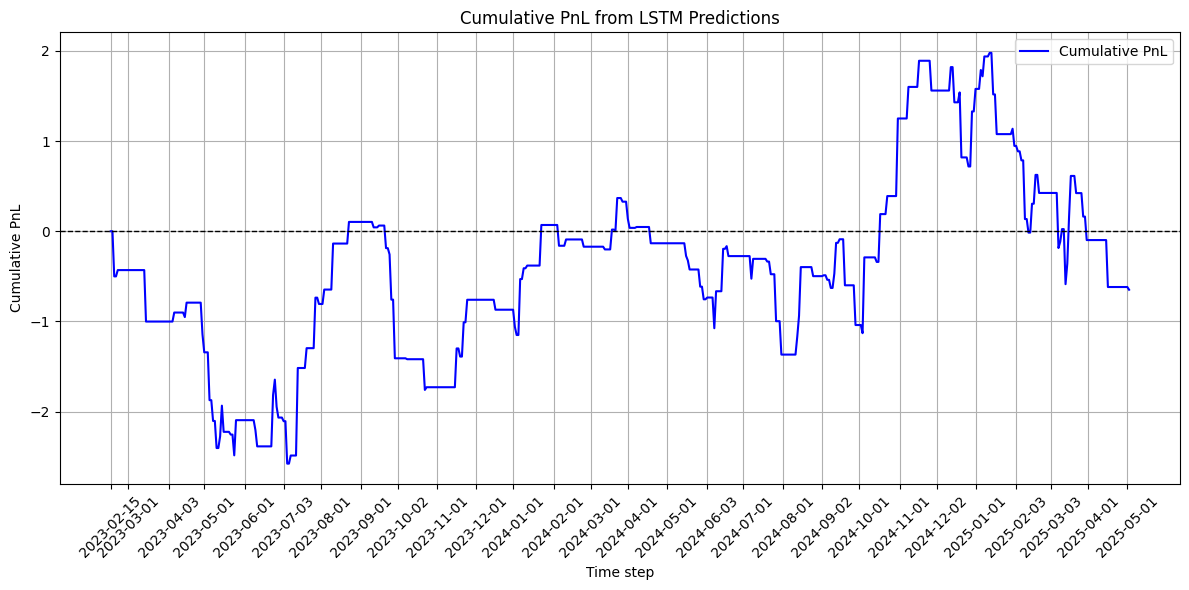

In [81]:
plot_cumulative_pnl(calculate_pnl(model_standard, x_train_lstm, x_test_lstm), dates)

Mean Std Dev: 0.352
Sharpe Ratio: 0.200
Annualized Sharpe Ratio: 3.173 

 mean PnL: 0.062 
 std PnL: 0.308 
 min PnL: -0.740 
 max PnL: 1.230
Total PnL: 35.632 
 - Number of trades: 	 131 
 - Avg PnL per trade: 	 0.272 
 - Win rate: 		 222.137% 
 - Average win: 	 0.288 
 - Average loss: 	 -0.192


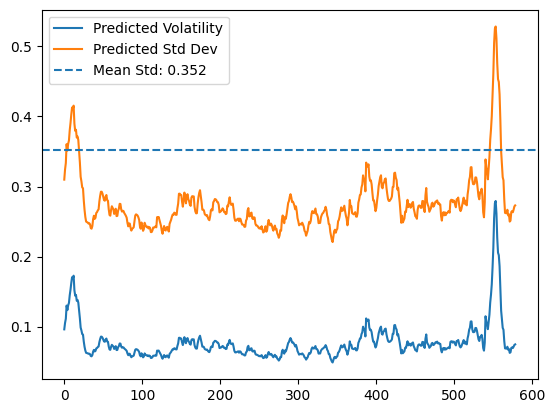

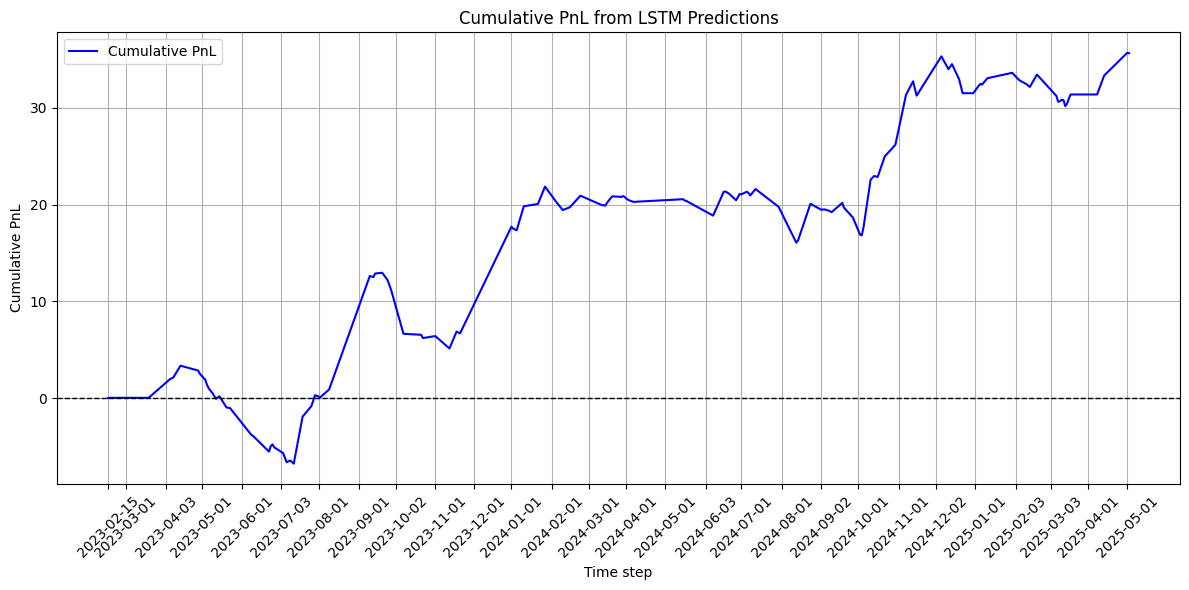

In [82]:
plot_cumulative_pnl(calculate_pnl(model_prob, x_train_lstm, x_test_lstm), dates)


#### Observations

- **Standard LSTM Strategy:** Trades are executed whenever the predicted return exceeds the threshold, regardless of uncertainty. Thus, the strategy may be more exposed to noisy predictions, as it does not account for model confidence. 

- **Probabilistic LSTM Strategy:** Trades are filtered by both the magnitude of the predicted return and the predicted uncertainty. This leads to fewer trades, but those trades are made when the model is more confident. The cumulative PnL plot is generally smoother, with fewer large drawdowns, and the Sharpe ratio is typically higher. The additional volatility filter helps avoid trades during uncertain periods, improving risk-adjusted returns.


#### Conclusion

The **probabilistic LSTM-based trading strategy** outperforms the standard approach in terms of both risk-adjusted and absolute returns. By incorporating model uncertainty into the trading decision, it avoids many poor trades and focuses on higher-confidence opportunities. This demonstrates the practical value of uncertainty-aware models in financial forecasting and trading. Non

**Disclaimer:**  
> The trading strategies and results presented here are based on historical data and simplified assumptions. In real-world scenarios, factors such as market impact, slippage, and changing market conditions can significantly affect performance. These results should not be interpreted as financial advice or as a recommendation for actual trading.